# GAN Model Evaluation Across Data Subsets

This notebook evaluates GAN models trained on different subsets of the MNIST dataset (from 10% to 90% of the full dataset). We'll use various metrics to assess the quality and performance of each model.

## Evaluation Metrics
1. **Fréchet Inception Distance (FID)**: Measures similarity between generated and real images
2. **Inception Score (IS)**: Measures quality and diversity of generated images
3. **Classification Accuracy**: How well a classifier recognizes generated digits
4. **Digit Distribution**: Assesses whether all digit classes are represented proportionally
5. **Visual Assessment**: Direct comparison of generated samples

These metrics will help determine how subset size affects GAN performance and whether there's a minimum effective subset size for MNIST.

In [37]:
# Save images and outputs of this notebook to an eval_results folder
import os
import torch
import random
import numpy as np

def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

eval_results_dir = "eval_results"
os.makedirs(eval_results_dir, exist_ok=True)
print(f"Created directory for evaluation results: {eval_results_dir}")

Created directory for evaluation results: eval_results


In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import os
import glob
from scipy.linalg import sqrtm
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

# Set random seed for reproducibility
set_random_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Model Architecture and Loading

First, we need to define the same model architecture used during training so we can load the saved models.

In [39]:
# Define hyperparameters - must match those used during training
latent_dim = 128
hidden_dim = 256
image_size = 28 * 28

class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 4, output_dim),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [40]:
set_random_seed(42)

def load_gan_model(subset_percentage):
    generator = Generator(latent_dim, hidden_dim, image_size).to(device)
    discriminator = Discriminator(image_size, hidden_dim).to(device)
    
    # Load saved model weights
    model_path = f"models/fashion_subset_{subset_percentage}_percent"
    
    generator.load_state_dict(torch.load(f"{model_path}/generator.pth", map_location=device))
    discriminator.load_state_dict(torch.load(f"{model_path}/discriminator.pth", map_location=device))
    
    # Set models to evaluation mode
    generator.eval()
    discriminator.eval()
    
    return generator, discriminator

def get_subset_percentages():
    dirs = glob.glob("models/fashion_subset_*_percent")
    percentages = []
    
    for dir_path in dirs:
        # Extract the percentage from the directory name
        percentage = int(dir_path.split("_")[2])
        percentages.append(percentage)
    
    return sorted(percentages)

subset_percentages = get_subset_percentages()
print(f"Found models for the following subset percentages: {subset_percentages}")

Found models for the following subset percentages: [50, 60, 70, 80, 90]


## 2. Data Loading

Let's load the MNIST test dataset to evaluate the performance of our GANs.

In [41]:
set_random_seed(42)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

test_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)

train_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)

# Function to get a batch of real images
def get_real_samples(n_samples=1000):
    dataloader = DataLoader(train_dataset, batch_size=n_samples, shuffle=True)
    real_images, labels = next(iter(dataloader))
    return real_images.to(device), labels.to(device)

# Function to generate fake images
def generate_fake_samples(generator, n_samples=1000):
    with torch.no_grad():
        z = torch.randn(n_samples, latent_dim).to(device)
        fake_images = generator(z)
    return fake_images

## 3. Evaluation Metrics

Now we'll implement various metrics to evaluate our GAN models.

### 3.1 CNN Classifier for Evaluation

We'll train a simple CNN classifier on the real MNIST data to help evaluate our generated images.

In [42]:
# Define a simple CNN classifier for MNIST
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def extract_features(self, x):
        # Used for FID calculation
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        return x

In [43]:
# Train or load a classifier
set_random_seed(42)
def get_classifier():
    classifier = MNISTClassifier().to(device)
    classifier_path = 'models/mnist_classifier.pth'
    
    # If the classifier already exists, load it
    if os.path.exists(classifier_path):
        classifier.load_state_dict(torch.load(classifier_path, map_location=device))
        print("Loaded pre-trained classifier model")
        return classifier
    
    # Otherwise, train a new classifier
    print("Training a new classifier model...")
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
    
    # Create a DataLoader for the training set
    train_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    # Train the classifier for 5 epochs
    for epoch in range(5):
        running_loss = 0.0
        for i, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/5")):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = classifier(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")
    
    # Save the trained classifier
    os.makedirs(os.path.dirname(classifier_path), exist_ok=True)
    torch.save(classifier.state_dict(), classifier_path)
    print("Classifier training complete and model saved")
    
    return classifier


classifier = get_classifier()

Loaded pre-trained classifier model


C:\Users\Christian\AppData\Local\Temp\ipykernel_4100\1082305977.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load(classifier_path, ma

### 3.2 Fréchet Inception Distance (FID) Score

FID measures the similarity between two sets of images by calculating the distance between their feature representations based on a features from a classifier trained on the mnist dataset.

In [44]:
# FID Score calculation
def calculate_fid(real_images, fake_images, feature_extractor):
    # Extract features
    with torch.no_grad():
        real_features = feature_extractor(real_images).detach().cpu().numpy()
        fake_features = feature_extractor(fake_images).detach().cpu().numpy()
    
    # Calculate mean and covariance statistics
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)
    
    # Calculate squared difference between means
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    
    # Calculate sqrt of product between covariances
    covmean = sqrtm(sigma1.dot(sigma2))
    
    # Check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    # Calculate FID
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

### 3.3 Inception Score (IS)

Inception Score evaluates the quality and diversity of generated images by assessing classifier confidence and class distribution.

In [45]:
# Calculate Inception Score
def calculate_inception_score(fake_images, classifier, eps=1e-16):
    classifier.eval()
    with torch.no_grad():
        # Get predictions
        predictions = F.softmax(classifier(fake_images), dim=1)
        predictions = predictions.detach().cpu().numpy()
        
        # Calculate p(y) - the marginal probability of a class
        p_y = np.mean(predictions, axis=0)
        
        # Calculate KL divergence
        kl_divs = []
        for p_x_given_y in predictions:
            # Calculate p(y|x) log(p(y|x) / p(y))
            kl = p_x_given_y * (np.log(p_x_given_y + eps) - np.log(p_y + eps))
            kl_divs.append(np.sum(kl))
        
        # Calculate the mean KL divergence
        is_score = np.exp(np.mean(kl_divs))
        
        return is_score

### 3.4 Classification Accuracy

This metric evaluates how well a classifier trained on real data can recognize the generated digits.

#### Average Confidence
The average confidence measures how "certain" the classifier is when identifying the generated images:

1. The classifier produces logits (raw scores) for each digit class (0-9)
2. These logits are converted to probabilities using softmax
3. For each image, we take the highest probability (the classifier's confidence in its top prediction)
4. We then average these maximum probabilities across all images

Higher average confidence indicates the GAN is producing images that clearly resemble specific digits, while lower values suggest the generated images are ambiguous.

#### Class Distribution
The class distribution reveals how evenly the GAN generates across all digit classes (0-9):

1. We count how many generated images are classified into each digit class
2. We normalize these counts to get a probability distribution

Ideally, a well-performing GAN should have a roughly uniform distribution (approximately 0.1 for each class), indicating it can generate all digits equally well. Significant deviations from uniformity may suggest mode collapse, where the GAN fails to generate certain digits or disproportionately favors others.

In [46]:
# Calculate classification accuracy on generated images
def calculate_classification_accuracy(fake_images, classifier, num_classes=10):
    classifier.eval()
    with torch.no_grad():
        # Get predictions
        predictions = classifier(fake_images)
        pred_classes = torch.argmax(predictions, dim=1).detach().cpu().numpy()
    
    # Count the predicted classes
    class_counts = np.bincount(pred_classes, minlength=num_classes)
    class_distribution = class_counts / np.sum(class_counts)
    
    # Calculate the confidence scores
    confidences = F.softmax(predictions, dim=1)
    avg_confidence = confidences.max(dim=1)[0].mean().item()
    
    return {
        'avg_confidence': avg_confidence,
        'class_distribution': class_distribution
    }

### 3.5 Mode Collapse Detection

This helper function visualizes the distribution of generated digits to detect mode collapse.

In [47]:
# Plot digit distribution to detect mode collapse
def plot_digit_distribution(class_distributions, percentages):
    plt.figure(figsize=(14, 8))
    
    bar_width = 0.8 / len(percentages)
    x = np.arange(10)  # 10 digit classes
    
    for i, percentage in enumerate(percentages):
        plt.bar(x + i*bar_width, class_distributions[percentage], width=bar_width, 
                label=f'{percentage}% subset')
    
    plt.xlabel('Digit')
    plt.ylabel('Frequency')
    plt.title('Distribution of Generated Digits Across Different Subset Sizes')
    plt.xticks(x + (len(percentages) - 1) * bar_width / 2, range(10))
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(eval_results_dir, 'digit_distribution.png'), dpi=300)
    plt.show()

### 3.6 Visual Comparison of Generated Samples

This function creates a grid of generated images from different subset percentages for visual comparison.

In [48]:
# Function to visualize samples from different models
def visualize_samples_from_models(generators, percentages, samples_per_model=10):
    # Use the same latent vectors for fair comparison
    fixed_noise = torch.randn(samples_per_model, latent_dim).to(device)
    
    # Generate images from each model
    with torch.no_grad():
        all_gen_imgs = []
        for percentage in percentages:
            gen_imgs = generators[percentage](fixed_noise).detach().cpu()
            # Rescale from [-1, 1] to [0, 1]
            gen_imgs = 0.5 * gen_imgs + 0.5
            all_gen_imgs.append(gen_imgs)
    
    # Create figure
    fig, axes = plt.subplots(len(percentages), samples_per_model, 
                             figsize=(2*samples_per_model, 2*len(percentages)))
    
    # Plot each image
    for i, percentage in enumerate(percentages):
        for j in range(samples_per_model):
            ax = axes[i, j] if len(percentages) > 1 else axes[j]
            img = all_gen_imgs[i][j].squeeze().numpy()
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            if j == 0:
                ax.set_title(f'{percentage}%', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(os.path.join(eval_results_dir, 'sample_comparison.png'), dpi=300)

    plt.show()

## 4. Evaluation Execution

Now we'll run all the evaluation metrics for each model and collect the results.

In [49]:
set_random_seed(42)
# Execute all evaluations
def evaluate_all_models(subset_percentages, num_samples=50000):
    results = {}
    generators = {}
    discriminators = {}
    class_distributions = {}
    
    # Get real samples once for FID calculation
    real_images, _ = get_real_samples(num_samples)
    
    for percentage in tqdm(subset_percentages, desc="Evaluating models"):
        # Load models
        generator, discriminator = load_gan_model(percentage)
        generators[percentage] = generator
        discriminators[percentage] = discriminator
        
        # Generate fake samples
        fake_images = generate_fake_samples(generator, num_samples)
        
        # Calculate FID score
        fid = calculate_fid(real_images, fake_images, classifier.extract_features)
        print(f"FID for {percentage}% subset: {fid:.4f}")
        
        # Calculate Inception Score
        is_score = calculate_inception_score(fake_images, classifier)
        
        # Calculate Classification metrics
        classification_metrics = calculate_classification_accuracy(fake_images, classifier)
        
        # Store results
        results[percentage] = {
            'fid': fid,
            'inception_score': is_score,
            'avg_confidence': classification_metrics['avg_confidence']
        }
        
        # Store class distributions for mode collapse analysis
        class_distributions[percentage] = classification_metrics['class_distribution']
    
    return results, generators, discriminators, class_distributions

# Run evaluation
results, generators, discriminators, class_distributions = evaluate_all_models(subset_percentages)

# Convert results to a pandas DataFrame for easier analysis
df_results = pd.DataFrame([results[p] for p in subset_percentages], index=subset_percentages)
df_results.index.name = 'subset_percentage'
df_results

Evaluating models:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\Christian\AppData\Local\Temp\ipykernel_4100\575894064.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(f"{model_path}/gener

FID for 50% subset: 59.5814
FID for 60% subset: 52.9652
FID for 70% subset: 34.3814
FID for 80% subset: 26.9519
FID for 90% subset: 13.5432


,fid,inception_score,avg_confidence
subset_percentage,,,
50,59.581352,2.162806,0.618869
60,52.965165,2.282754,0.628235
70,34.381424,2.508643,0.642270
80,26.951858,2.621101,0.653684
90,13.543171,2.795257,0.623206


## 5. Results Visualization

Let's create visualizations to better understand how the different metrics vary with subset size.

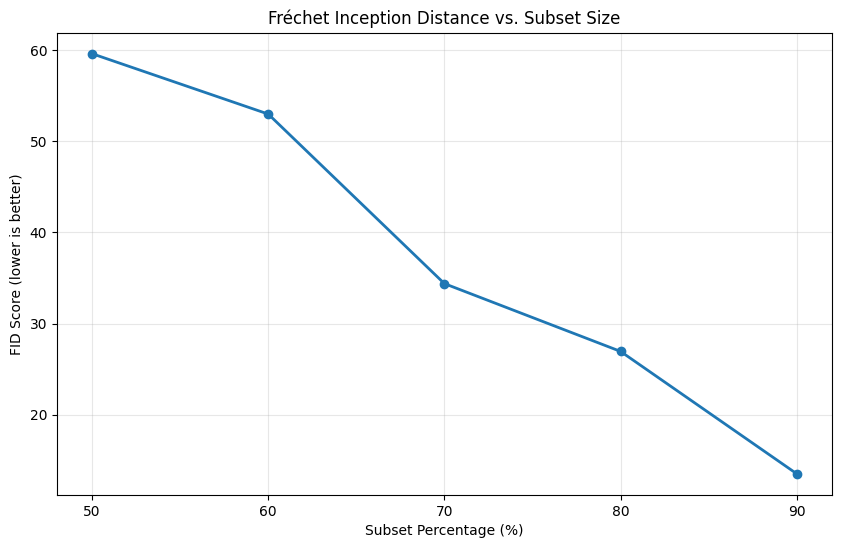

In [50]:
# Plot FID scores
plt.figure(figsize=(10, 6))
plt.plot(subset_percentages, [results[p]['fid'] for p in subset_percentages], marker='o', linewidth=2)
plt.xlabel('Subset Percentage (%)')
plt.ylabel('FID Score (lower is better)')
plt.title('Fréchet Inception Distance vs. Subset Size')
plt.grid(True, alpha=0.3)
plt.xticks(subset_percentages)
plt.savefig(os.path.join(eval_results_dir, 'fid_scores.png'), dpi=300)
plt.show()

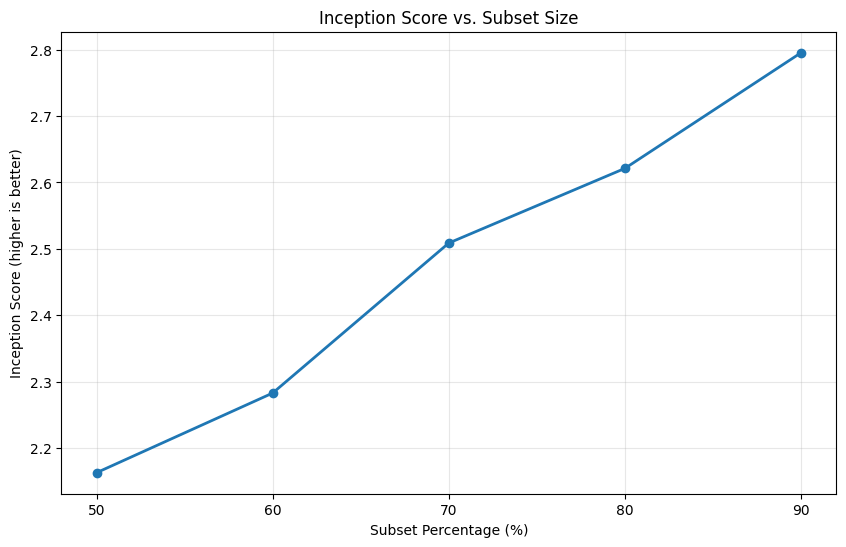

In [51]:
# Plot Inception scores
plt.figure(figsize=(10, 6))
plt.plot(subset_percentages, [results[p]['inception_score'] for p in subset_percentages], marker='o', linewidth=2)
plt.xlabel('Subset Percentage (%)')
plt.ylabel('Inception Score (higher is better)')
plt.title('Inception Score vs. Subset Size')
plt.grid(True, alpha=0.3)
plt.xticks(subset_percentages)
plt.savefig(os.path.join(eval_results_dir, 'inception_scores.png'), dpi=300)
plt.show()

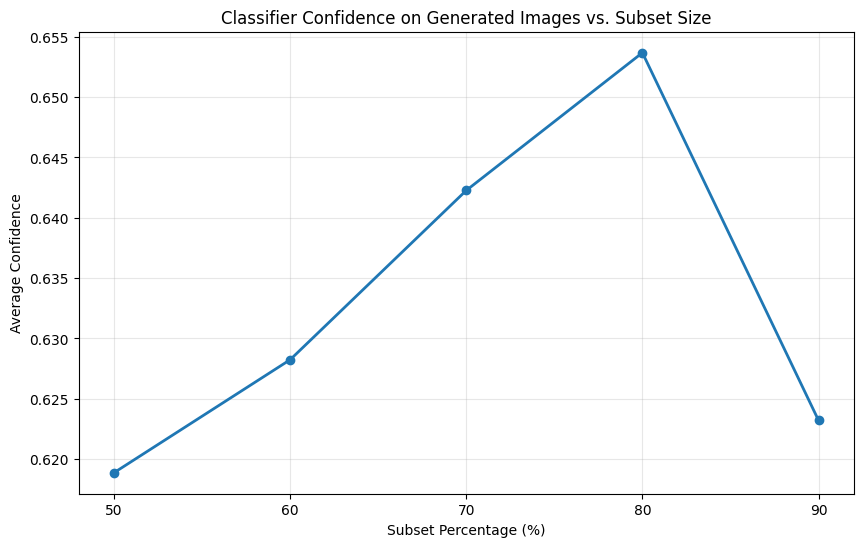

In [52]:
# Plot average confidence
plt.figure(figsize=(10, 6))
plt.plot(subset_percentages, [results[p]['avg_confidence'] for p in subset_percentages], marker='o', linewidth=2)
plt.xlabel('Subset Percentage (%)')
plt.ylabel('Average Confidence')
plt.title('Classifier Confidence on Generated Images vs. Subset Size')
plt.grid(True, alpha=0.3)
plt.xticks(subset_percentages)
plt.savefig(os.path.join(eval_results_dir, 'confidence_scores.png'), dpi=300)
plt.show()

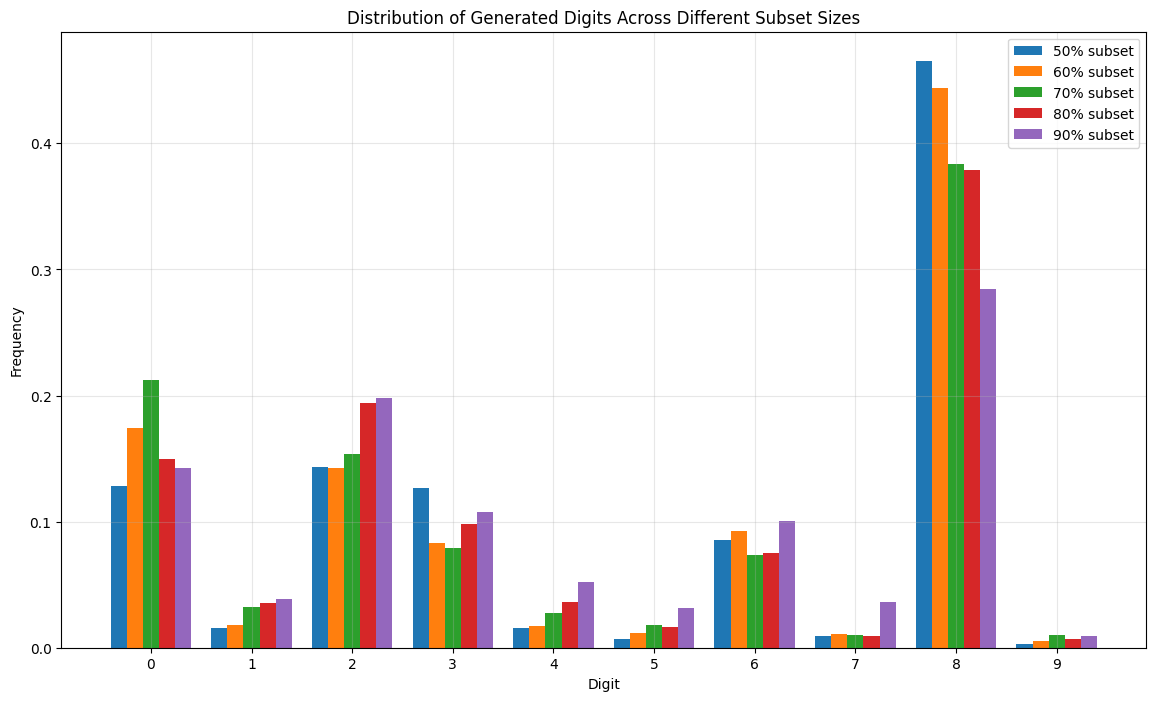

In [53]:
# Plot digit distributions to detect mode collapse
plot_digit_distribution(class_distributions, subset_percentages)

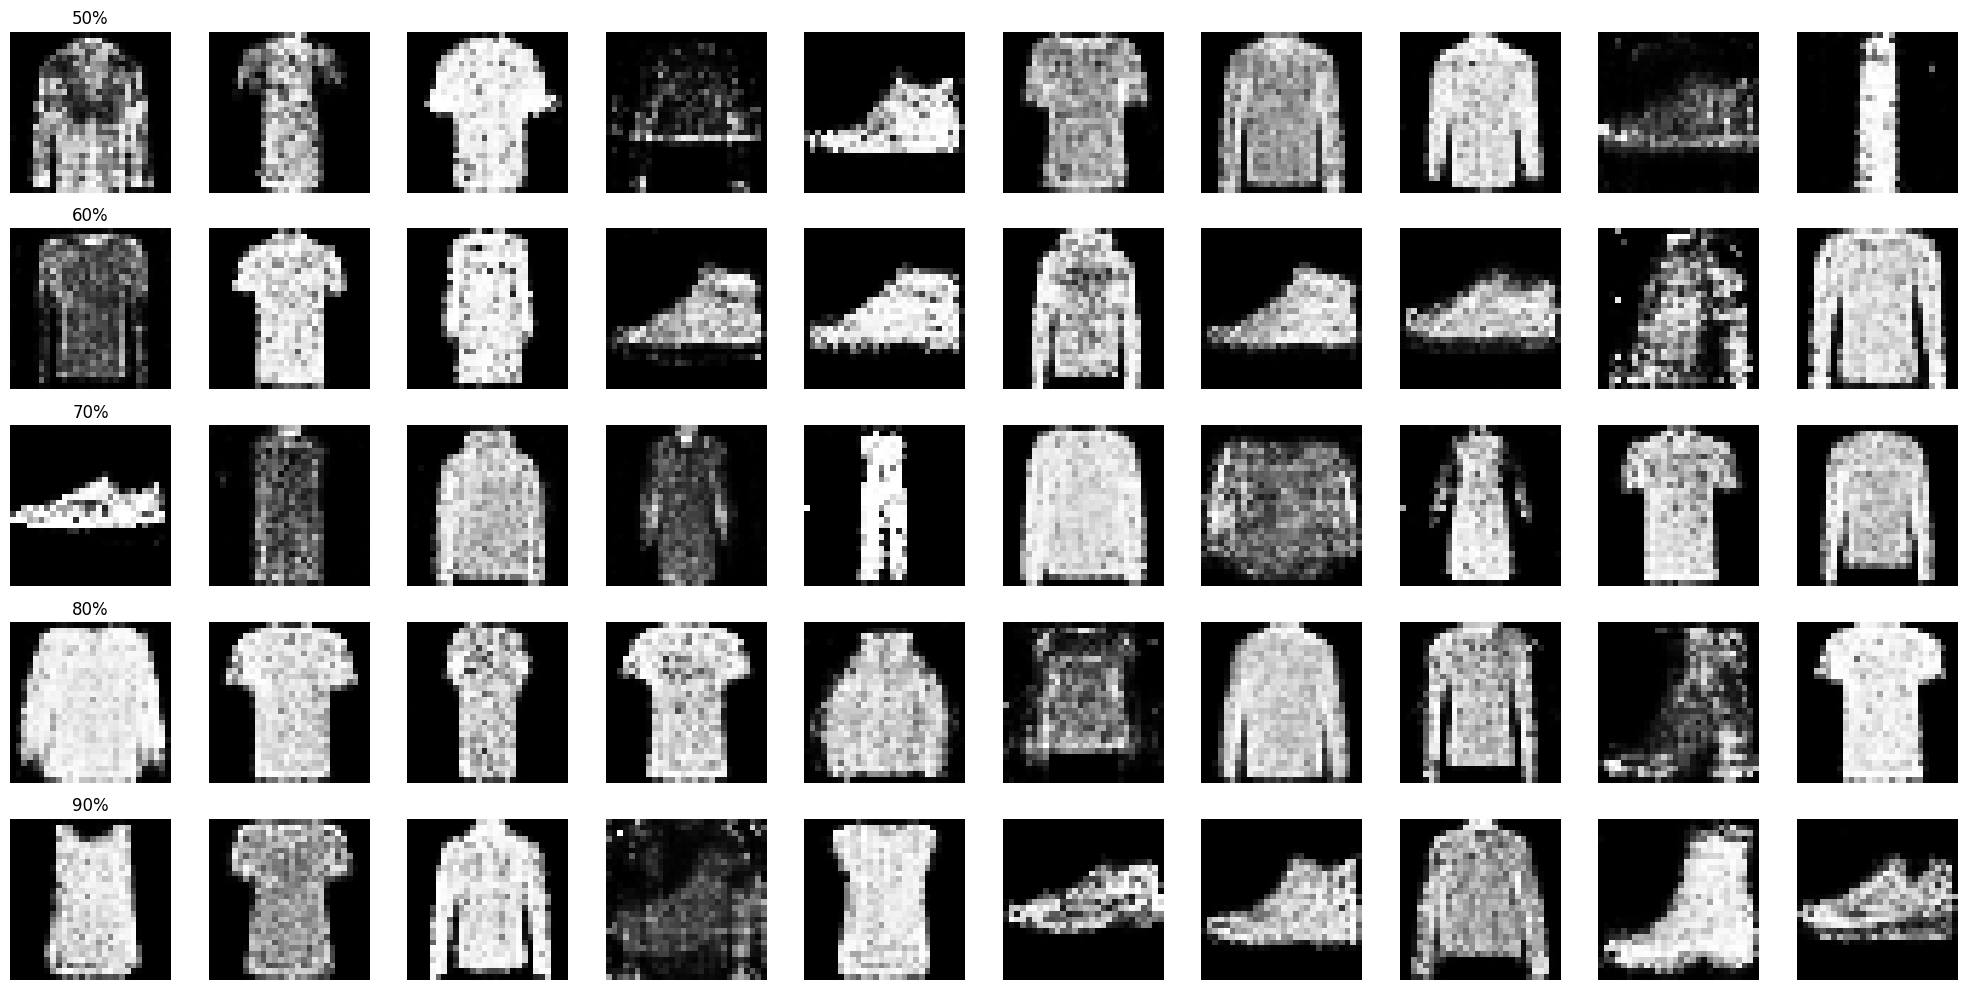

In [54]:
# Visualize samples from different models
visualize_samples_from_models(generators, subset_percentages)